# The Data
In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain (“angina”) during exercise.

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, roc_auc_score, f1_score, roc_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns

#suppress convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)
pd.options.mode.chained_assignment = None

In [48]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.dropna(inplace=True)

ha[["sex", "cp", "restecg", "output"]] = ha[["sex", "cp", "restecg", "output"]].astype("object")

ha.describe()

,age,trtbps,chol,thalach
count,273.000000,273.000000,273.000000,273.000000
mean,54.347985,132.098901,246.860806,149.446886
std,9.163134,17.700358,52.569726,23.240707
min,29.000000,94.000000,126.000000,71.000000
25%,47.000000,120.000000,211.000000,133.000000
50%,56.000000,130.000000,240.000000,152.000000
75%,61.000000,140.000000,275.000000,166.000000
max,77.000000,200.000000,564.000000,202.000000


In [49]:
# make sure output column is int

ha["output"] = ha["output"].astype(int)

# Part One: Fitting the Models

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

* Find the best model based on ROC AUC for predicting the target variable.

* Report the (cross-validated!) ROC AUC metric.

* Fit the final model.

* Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

* (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

## Q1: KNN

In [50]:
X = ha.drop("output", axis = 1)
y = ha["output"]



# create pipelines

ct = ColumnTransformer([("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
                                        make_column_selector(dtype_include=object)),
                            ("standardize", StandardScaler(), 
                                        make_column_selector(dtype_include=np.number))],
                                        remainder = "passthrough")

knn_pipeline = Pipeline(
    [("preprocessing", ct),
    ("classifier", KNeighborsClassifier())]
)


# write function

def best_features(X, y, model_type = "knn", parameters):
    # create criteria for model specification
    if model_type  == "knn":
        model = KNeighborsClassifier()
        params = {
            "classifier__"

        }
    elif model_type == "ridge":
        model = Ridge()
        alpha = {"regression__alpha": alpha_values}
        l1_ratio = {}
    elif model_type == "lasso":
        model = Lasso()
        alpha = {"regression__alpha": alpha_values}
        l1_ratio = {}
    elif model_type == "elasticnet":
        model = ElasticNet()
        alpha = {"regression__alpha": alpha_values, "regression__l1_ratio": l1_ratio_values}
    else:
        raise ValueError("Unsupported model_type. Choose from 'lasso', 'ridge', 'elasticnet', or 'linear'.")


SyntaxError: non-default argument follows default argument (928980936.py, line 22)

Best ROC AUC (Cross-Validation): 0.8817339544513458
Test ROC AUC: 0.6631299734748011
Best ROC AUC (Cross-Validation): 0.8817339544513458
Test ROC AUC: 0.6631299734748011


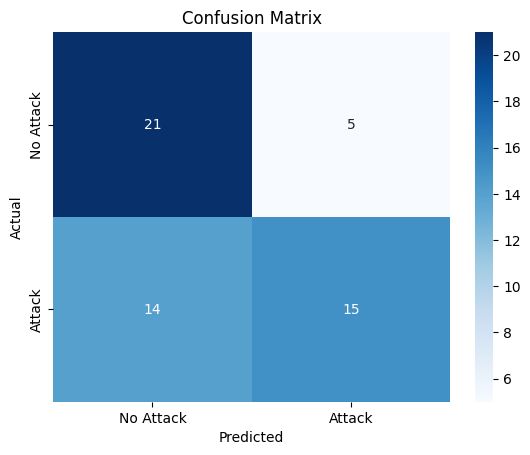

              precision    recall  f1-score   support

           0       0.60      0.81      0.69        26
           1       0.75      0.52      0.61        29

    accuracy                           0.65        55
   macro avg       0.68      0.66      0.65        55
weighted avg       0.68      0.65      0.65        55

              precision    recall  f1-score   support

           0       0.60      0.81      0.69        26
           1       0.75      0.52      0.61        29

    accuracy                           0.65        55
   macro avg       0.68      0.66      0.65        55
weighted avg       0.68      0.65      0.65        55



In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

import matplotlib.pyplot as plt

# Fix the target variable if continuous
#y = (y >= 0.5).astype(int)  # Example threshold for binary classification

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create KNN pipeline
knn = KNeighborsClassifier()

knn_pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', knn)
])

knn_param_grid = {
    'classifier__n_neighbors': np.arange(1, 31),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

# Retrieve the best model and evaluate
best_knn_model = knn_grid_search.best_estimator_
best_knn_score = knn_grid_search.best_score_

print("Best ROC AUC (Cross-Validation):", best_knn_score)

y_test_pred = best_knn_model.predict(X_test)
y_test_pred_prob = best_knn_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
print("Test ROC AUC:", test_roc_auc)

conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attack', 'Attack'], yticklabels=['No Attack', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_test_pred))


Best ROC AUC (Cross-Validation): 0.8572
Test ROC AUC: 0.8475
Best ROC AUC (Cross-Validation): 0.8572
Test ROC AUC: 0.8475


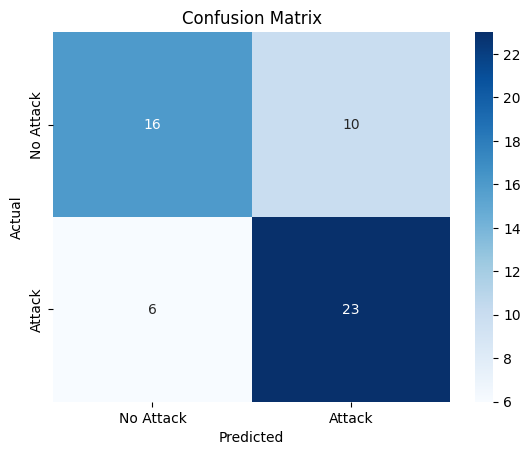

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        26
           1       0.70      0.79      0.74        29

    accuracy                           0.71        55
   macro avg       0.71      0.70      0.70        55
weighted avg       0.71      0.71      0.71        55

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        26
           1       0.70      0.79      0.74        29

    accuracy                           0.71        55
   macro avg       0.71      0.70      0.70        55
weighted avg       0.71      0.71      0.71        55



/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means

Best ROC AUC (Cross-Validation): 0.8603
Test ROC AUC: 0.8886
Best ROC AUC (Cross-Validation): 0.8603
Test ROC AUC: 0.8886


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means

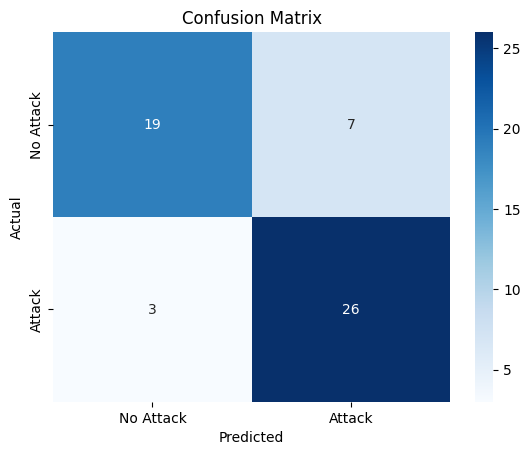

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        26
           1       0.79      0.90      0.84        29

    accuracy                           0.82        55
   macro avg       0.83      0.81      0.82        55
weighted avg       0.82      0.82      0.82        55

Model Coefficients:
[[ 1.12251609 -0.74974079 -1.33587658  0.68653759  0.78551425  0.23660004  0.0947962   0.49182042 -0.21384131 -0.21954178 -0.38550816 -0.15737508  0.8234291 ]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        26
           1       0.79      0.90      0.84        29

    accuracy                           0.82        55
   macro avg       0.83      0.81      0.82        55
weighted avg       0.82      0.82      0.82        55

Model Coefficients:
[[ 1.12251609 -0.74974079 -1.33587658  0.68653759  0.78551425  0.23660004  0.0947962   0.49182042 -0

Best ROC AUC (Cross-Validation): 0.7924
Test ROC AUC: 0.8130
Best ROC AUC (Cross-Validation): 0.7924
Test ROC AUC: 0.8130


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


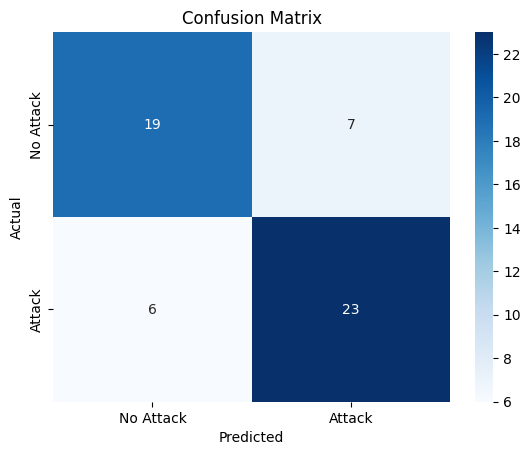

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75        26
           1       0.77      0.79      0.78        29

    accuracy                           0.76        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.76      0.76      0.76        55

Feature Importances:
[0.         0.09063313 0.53248296 0.         0.         0.         0.         0.         0.         0.17248158 0.0417315  0.         0.16267083]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75        26
           1       0.77      0.79      0.78        29

    accuracy                           0.76        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.76      0.76      0.76        55

Feature Importances:
[0.         0.09063313 0.53248296 0.         0.         0.         0.         0.         0.         0.17248158 0.

In [60]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the function
def evaluate_model(classifier, X, y, param_grid, cv=5):
    """
    Evaluates a classifier using GridSearchCV based on ROC AUC, and reports the results.
    
    Parameters:
    - classifier: The model to be evaluated (e.g., KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier)
    - X: Feature matrix
    - y: Target variable
    - param_grid: Dictionary of hyperparameters for GridSearchCV
    - cv: Cross-validation folds (default is 5)
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

    # Create pipeline with preprocessing and classifier
    knn_pipeline = Pipeline([
        ('preprocessor', ct),
        ('classifier', classifier)
    ])

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(knn_pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model and ROC AUC score from cross-validation
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

    print(f"Best ROC AUC (Cross-Validation): {best_score:.4f}")

    # Evaluate the best model on the test set
    y_test_pred = best_model.predict(X_test)
    y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
    print(f"Test ROC AUC: {test_roc_auc:.4f}")

    # Display the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attack', 'Attack'], yticklabels=['No Attack', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Output classification report
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # If applicable (e.g., Logistic Regression or Decision Tree), interpret coefficients/feature importances
    if hasattr(best_model.named_steps['classifier'], 'coef_'):  # Logistic Regression
        print("Model Coefficients:")
        print(best_model.named_steps['classifier'].coef_)
    elif hasattr(best_model.named_steps['classifier'], 'feature_importances_'):  # Decision Tree
        print("Feature Importances:")
        print(best_model.named_steps['classifier'].feature_importances_)

# Example usage for KNN, Logistic Regression, and Decision Tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grids for each model
knn_param_grid = {
    'classifier__n_neighbors': np.arange(1, 31),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

log_reg_param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Regularization strength
    'classifier__solver': ['liblinear', 'saga']
}

dt_param_grid = {
    'classifier__max_depth': np.arange(1, 21),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Call the function with different classifiers

# For KNN
evaluate_model(KNeighborsClassifier(), X, y, knn_param_grid)

# For Logistic Regression
evaluate_model(LogisticRegression(), X, y, log_reg_param_grid)

# For Decision Tree
evaluate_model(DecisionTreeClassifier(), X, y, dt_param_grid)
